camera calibration with planar calibration target using the method described by Zhang

(only the initial estimate ignoring distortion)

sources:

- Zhang et al. A flexible approach to camera calibration.


calibration patterns: 20mm slightly too small to detect reliably. 25mm is OK. the more points, the better! with 25mm, can only get 60 points for each image.

In [56]:
# load the images
import pathlib

image_dir = "calibration_images"

all_images = pathlib.Path(image_dir).glob('*.png')
all_images = [str(path) for path in all_images]

print(all_images)



['calibration_images/92.png', 'calibration_images/97.png', 'calibration_images/27.png', 'calibration_images/28.png', 'calibration_images/84.png', 'calibration_images/70.png', 'calibration_images/36.png', 'calibration_images/95.png', 'calibration_images/45.png', 'calibration_images/44.png', 'calibration_images/94.png', 'calibration_images/29.png', 'calibration_images/61.png', 'calibration_images/86.png', 'calibration_images/56.png', 'calibration_images/98.png', 'calibration_images/32.png', 'calibration_images/43.png', 'calibration_images/14.png', 'calibration_images/24.png', 'calibration_images/7.png', 'calibration_images/59.png', 'calibration_images/76.png', 'calibration_images/75.png', 'calibration_images/21.png', 'calibration_images/23.png', 'calibration_images/60.png', 'calibration_images/34.png', 'calibration_images/55.png', 'calibration_images/37.png', 'calibration_images/78.png', 'calibration_images/65.png', 'calibration_images/72.png', 'calibration_images/68.png', 'calibration_i

In [57]:
# for all images, load the image and detect the marker corners using opencv

import cv2
import cv2.aruco
import numpy as np
np.set_printoptions(precision=4, suppress=True)


rejected_images = []

# see the pdf file in the airo-camera-toolkit/docs folder
aruco_dict =  cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
charuco_board = cv2.aruco.CharucoBoard((11,7), 0.025, 0.018, aruco_dict)
corner_dict = {}

for image in all_images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

    n_corners, charuco_corners, ids = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, charuco_board)

    # for i in range(len(ids) - 1):
    #     if ids[i] !=i:
    #         print(f"Error: {image} has unsorted ids")
    #         rejected_images.append(image)
    #         break
    if n_corners > 0:
        # refine corners
        charuco_corners = cv2.cornerSubPix(gray, charuco_corners, winSize=(3, 3), zeroZone=(-1, -1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01))

    if not len(charuco_corners) == 60:
        print(f"Error: {image} has {len(charuco_corners)} corners")
        rejected_images.append(image)
    else:
        corner_dict[image] = {"corners": corners, "charuco_corners": charuco_corners, "ids": ids}

print(f"Rejected images: {rejected_images}")
all_images = [image for image in all_images if image not in rejected_images]

# visualize the detected corners
import matplotlib.pyplot as plt

for image in all_images:
    img = cv2.imread(image)
    corners = corner_dict[image]
    img = cv2.aruco.drawDetectedCornersCharuco(img, np.array(corners["charuco_corners"]), np.array(corners["ids"]), (0, 255, 0))

    # convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img)
    plt.show()

Error: calibration_images/92.png has 58 corners
Error: calibration_images/97.png has 56 corners
Error: calibration_images/45.png has 54 corners
Error: calibration_images/29.png has 58 corners
Error: calibration_images/43.png has 58 corners
Error: calibration_images/24.png has 54 corners
Error: calibration_images/59.png has 56 corners
Error: calibration_images/60.png has 56 corners
Error: calibration_images/34.png has 58 corners
Error: calibration_images/58.png has 56 corners
Error: calibration_images/49.png has 54 corners
Error: calibration_images/53.png has 56 corners
Error: calibration_images/64.png has 56 corners
Error: calibration_images/46.png has 58 corners
Error: calibration_images/41.png has 58 corners
Error: calibration_images/66.png has 54 corners
Error: calibration_images/79.png has 56 corners
Error: calibration_images/62.png has 58 corners
Error: calibration_images/47.png has 56 corners
Error: calibration_images/52.png has 58 corners
Error: calibration_images/26.png has 58 

In [58]:
print(len(all_images))

75


In [59]:
# create real-world planar coordinates. points are in a 4x6 grid with 40mm spacing 

# create the planar coordinates
planar_coords = []
for j in range(6):
    for i in range(10):
        planar_coords.append([i*0.025, j*0.025, 0])
print(planar_coords)



[[0.0, 0.0, 0], [0.025, 0.0, 0], [0.05, 0.0, 0], [0.07500000000000001, 0.0, 0], [0.1, 0.0, 0], [0.125, 0.0, 0], [0.15000000000000002, 0.0, 0], [0.17500000000000002, 0.0, 0], [0.2, 0.0, 0], [0.225, 0.0, 0], [0.0, 0.025, 0], [0.025, 0.025, 0], [0.05, 0.025, 0], [0.07500000000000001, 0.025, 0], [0.1, 0.025, 0], [0.125, 0.025, 0], [0.15000000000000002, 0.025, 0], [0.17500000000000002, 0.025, 0], [0.2, 0.025, 0], [0.225, 0.025, 0], [0.0, 0.05, 0], [0.025, 0.05, 0], [0.05, 0.05, 0], [0.07500000000000001, 0.05, 0], [0.1, 0.05, 0], [0.125, 0.05, 0], [0.15000000000000002, 0.05, 0], [0.17500000000000002, 0.05, 0], [0.2, 0.05, 0], [0.225, 0.05, 0], [0.0, 0.07500000000000001, 0], [0.025, 0.07500000000000001, 0], [0.05, 0.07500000000000001, 0], [0.07500000000000001, 0.07500000000000001, 0], [0.1, 0.07500000000000001, 0], [0.125, 0.07500000000000001, 0], [0.15000000000000002, 0.07500000000000001, 0], [0.17500000000000002, 0.07500000000000001, 0], [0.2, 0.07500000000000001, 0], [0.225, 0.075000000000

In [60]:
# for each image, find the homography

homography_dict = {}

for image in all_images:
    corners = corner_dict[image]
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # make the corners homogeneous
    img_corners  = np.array(corners["charuco_corners"])
    # drop second dimension
    img_corners = img_corners.reshape(-1,2)
    img_corners = np.hstack([img_corners, np.ones((img_corners.shape[0],1))])

    # make world coords XY homogeneous
    p = np.array(planar_coords)
    p[:,2] = 1
    

    # find the homography
    H,retval = cv2.findHomography(p, img_corners)
   # print(H)

    # check 
    # get reprojection error

    # project the planar coordinates to the image
    img_coords = np.dot(H, p.T)
    img_coords = img_coords/img_coords[2,:]
    img_coords = img_coords[:2,:].T
    img_coords = img_coords.reshape(-1,2)

    distances = np.linalg.norm(img_coords - img_corners[:,:2], axis=1)
    l2_error = np.average(distances)
    print(l2_error)

    homography_dict[image] = {"H": H, "l2_error": l2_error}



0.3710893895978173
0.39127393028086777
0.9629500258828609
0.25901475161351717
0.31440767977350004
0.37690018186285845
0.2829710829231102
0.35940499257995656
0.2901286097160234
0.7395118372307569
0.27324146958067613
0.315507706482227
0.7522992928822138
1.6271893101248815
1.273041946846661
0.3450113741750896
0.37428064450153836
1.2758189952957126
1.3384883104384449
0.7160427634417558
0.34852561988308567
0.38838738340049406
0.2767036818407497
0.3917634822913619
1.1996513498614712
0.5019078074619696
0.4597359001680165
0.5269121313512766
0.29315922055521265
0.557682000849777
1.27377272612345
0.5060866445943678
0.5122120361770963
0.7340076307194866
1.7600710672113786
0.3011292272225979
0.3071966099597943
0.5300924698111091
0.6964547937699922
0.45884054224360127
0.2524875725784162
0.24594337655914156
1.8872982964190181
0.5558910156393526
0.29884320672585535
4.516692370750187
0.796825161392957
1.1660115407032945
1.2875376891276666
1.4245438569407194
1.670693109173285
1.4098829613749913
0.37094

In [98]:
# calibrate camera using zhang method algebraic solution


# def v_ij(H,i,j):
#     row = [H[i,0]*H[j,0], H[i,0]*H[j,1] + H[i,1]*H[j,0], H[i,1]*H[j,1], H[i,2]*H[j,0] + H[i,0]*H[j,2], H[i,2]*H[j,1] + H[i,1]*H[j,2], H[i,2]*H[j,2]]
#     return np.array(row)

def v_ij(H,i,j):
    row = [H[0,i]*H[0,j], H[0,i]*H[1,j] + H[1,i]*H[0,j], H[1,i]* H[1,j], H[2,i]*H[0,j] + H[0,i]*H[2,j],H[2,i]*H[1,j]+H[1,i]*H[2,j],H[2,i]*H[2,j]]
    return np.array(row)

V = np.zeros((2*len(all_images), 6))
for i,img_path in enumerate(homography_dict.keys()):
    H = homography_dict[img_path]["H"]
    V[2*i] = v_ij(H,0,1)
    V[2*i+1] = v_ij(H,0,0) - v_ij(H,1,1)

print(V[0])
U,S,Vt = np.linalg.svd(V)
b = Vt[-1]
print(b)
B = np.array([[b[0], b[1], b[3]], [b[1], b[2], b[4]], [b[3], b[4], b[5]]])

v0 = (B[0,1]*B[0,2] - B[0,0]*B[1,2])/(B[0,0]*B[1,1] - B[0,1]*B[0,1])
l = B[2,2] - (B[0,2]*B[0,2] + v0*(B[0,1]*B[0,2] - B[0,0]*B[1,2]))/B[0,0]
alpha = np.sqrt(l/B[0,0])
beta = np.sqrt(l*B[0,0]/(B[0,0]*B[1,1] - B[0,1]*B[0,1]))
gamma = -B[0,1]*alpha*alpha*beta/l
u0 = gamma*v0/alpha - B[0,2]*alpha*alpha/l


K = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
print(K)
                        

[-1277169.32   3695467.467  -382147.737    -2122.206      336.197
       -0.066]
[ 0. -0.  0. -0. -0.  1.]
[[1383.479    3.655  949.892]
 [   0.    1383.577  557.101]
 [   0.       0.       1.   ]]


## opencv built-in method

In [62]:
# use opencv to calibrate
import random 
objPoints = []
imgPoints = []

calib_images = random.sample(all_images, 60)

for img in calib_images:
    corners = corner_dict[img]
    objPoints.append(np.array(planar_coords))
    imgPoints.append(corners["charuco_corners"])

objPoints = np.array(objPoints)
print(objPoints.shape)
imgPoints = np.array(imgPoints)
imgPoints = imgPoints.reshape(imgPoints.shape[0],imgPoints.shape[1],2)
print(imgPoints.shape)
imgPoints = imgPoints.astype(np.float32)
objPoints = objPoints.astype(np.float32)

# no distortion optimization!
retval, cameraMatrix, distCoeffs, rvecs, tvecs, std_dev_intrinsics,std_dev_extrinsics,per_view_rms = cv2.calibrateCameraExtended(objPoints, imgPoints, gray.shape[::-1], None, np.zeros(5), flags=cv2.CALIB_FIX_K3 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_TANGENT_DIST)

np.set_printoptions(precision=3)
print(cameraMatrix)

print(distCoeffs)




(60, 60, 3)
(60, 60, 2)
[[1381.467    0.     960.995]
 [   0.    1382.512  561.762]
 [   0.       0.       1.   ]]
[0. 0. 0. 0. 0.]


In [63]:
print(np.average(per_view_rms))


1.1707143675350917


In [64]:
# for each image, reproject the planar coordinates to the image using the estimated camera matrix and extrinsics.
reprojection_errors = []
for i, img_path in enumerate(calib_images):
    world_coords = np.array(planar_coords)
    rvec = rvecs[i]
    tvec = tvecs[i]

    # create homogeneous matrix from tvec and rvec 
    R,_ = cv2.Rodrigues(rvec)
    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = tvec.flatten()

    # project the planar coordinates to the image
    img_coords_cv = cv2.projectPoints(world_coords.T, rvec, tvec, cameraMatrix, distCoeffs)[0].reshape(-1,2)

    # can only do this w/o undistorting if the distortion is zero
    world_coords = np.hstack([world_coords, np.ones((world_coords.shape[0],1))]).T
    img_coords = cameraMatrix@ (T @ world_coords)[:3,:]
    img_coords = img_coords/img_coords[2,:]
    img_coords = img_coords[:2,:].T
    reprojection_error = img_coords - imgPoints[i]
    reprojection_errors.extend(reprojection_error)


    # show image coords on the image
    img = cv2.imread(img_path)
    for j in range(len(img_coords)):
        cv2.circle(img, (int(img_coords[j,0]), int(img_coords[j,1])), 5, (255,0,0), -1)
    img = cv2.aruco.drawDetectedCornersCharuco(img, np.array(corner_dict[img_path]["charuco_corners"]), np.array(corner_dict[img_path]["ids"]), (0, 255, 0))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if i % 10 == 0:
        #plt.imshow(img)
        plt.show()
        pass


reprojection_distances = np.linalg.norm(reprojection_errors, axis=1)
reprojection_error = np.mean(reprojection_distances)
print(f"Reprojection error: {reprojection_error} pixels")
    


Reprojection error: 1.017927420250428 pixels


(-5.0, 5.0)

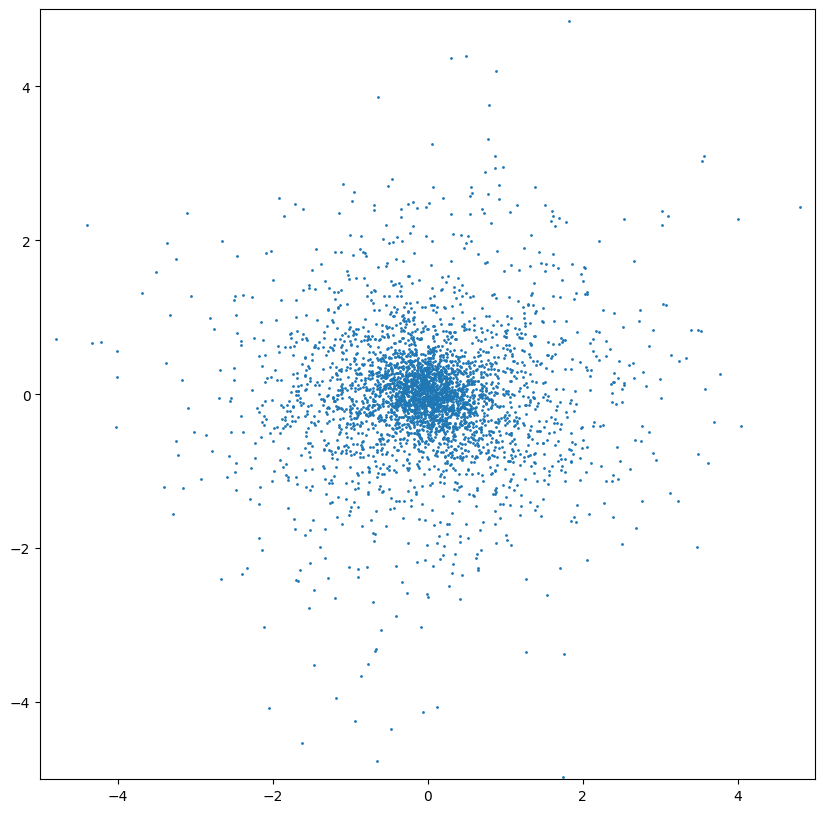

In [65]:
# plot reprojection distances

# create square figure
plt.figure(figsize=(10,10))
reprojection_errors = np.array(reprojection_errors)
plt.scatter(reprojection_errors[:,0], reprojection_errors[:,1], s=1)
plt.xlim(-5,5)
plt.ylim(-5,5)


In [66]:
import pyrealsense2 as rs

# shut camera down if it is running
ctx = rs.context()
devices = ctx.query_devices()
for dev in devices:
    dev.hardware_reset()

config = rs.config()

config.enable_stream(rs.stream.color, 1920,1080, rs.format.rgb8, 15)

# Avoid having to reconnect the USB cable, see https://github.com/IntelRealSense/librealsense/issues/6628#issuecomment-646558144
ctx = rs.context()
devices = ctx.query_devices()
for dev in devices:
    dev.hardware_reset()

pipeline = rs.pipeline()

pipeline.start(config)
# Get intrinsics matrix
profile = pipeline.get_active_profile()
color_profile = rs.video_stream_profile(profile.get_stream(rs.stream.color))
intrinsics = color_profile.get_intrinsics()
intrinsics_matrix = np.array(
    [
        [intrinsics.fx, 0, intrinsics.ppx],
        [0, intrinsics.fy, intrinsics.ppy],
        [0, 0, 1],
    ]
)

print(intrinsics_matrix)

[[1372.015    0.     967.68 ]
 [   0.    1369.215  558.417]
 [   0.       0.       1.   ]]
